In [1]:
from IPython import get_ipython
import random
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from dynamic_env import TaskEnv_drift
from typing import Tuple, List
import itertools as it
import numpy as np
import pandas as pd
import plotly.express as px
import statistics as s



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from collections import deque
import ast

In [3]:
env = TaskEnv_drift()

/Users/veetin/Desktop/drifttest_pa/main/dynamic_env.py:47: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错


In [3]:
def drift_control(add_states=0,add_actions=0, type_drif=None): #add other variable to control the type
    """which episode drift happen and which type""" 
    env.set_flag()
    env.drift(add_actions,add_states)
    #qlearner.change_qtable()
    return

In [5]:
# 定义 State-Action Embedding 和 Q-Network
class StateActionEmbedding(nn.Module):
    def __init__(self, state_dim, action_dim, embedding_dim=16):
        super(StateActionEmbedding, self).__init__()
        self.state_embedding = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )
        self.action_embedding = nn.Sequential(
            nn.Linear(action_dim, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )

    def forward(self, state, action):
        state_embed = self.state_embedding(state)
        action_embed = self.action_embedding(action)
        return torch.cat([state_embed, action_embed], dim=-1)

class QNetwork(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=64):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state_action_embed):
        return self.fc(state_action_embed)

# 定义 DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, embedding_dim=16, gamma=0.9, lr=1e-3, epsilon=0.2, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.losses = []
        self.episode_rewards = []

        # 网络
        self.embedding_net = StateActionEmbedding(state_dim, action_dim, embedding_dim)
        self.q_net = QNetwork(embedding_dim)
        self.target_q_net = QNetwork(embedding_dim)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        # 优化器
        self.optimizer = optim.Adam(list(self.embedding_net.parameters()) + list(self.q_net.parameters()), lr=lr)

        # 经验回放
        self.memory = deque(maxlen=100)

    def get_action(self, state, state_to_index):
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_dim - 1)  # 随机动作
        else:
            state_index = state_to_index[state]  # 将 state 转换为索引
            state_one_hot = torch.zeros(self.state_dim).unsqueeze(0)
            state_one_hot[0, state_index] = 1  # 转换为 one-hot 编码
            q_values = []
            for action in range(self.action_dim):
                action_one_hot = torch.zeros(self.action_dim).unsqueeze(0)
                action_one_hot[0, action] = 1
                state_action_embed = self.embedding_net(state_one_hot, action_one_hot)
                q_value = self.q_net(state_action_embed)
                q_values.append(q_value.item())
            return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size=1, state_to_index=None):
        if len(self.memory) < batch_size:
            return

        # 从经验回放中采样一个样本（batch_size=1）
        state, action, reward, next_state, done = self.memory[-1]

        # 将 state 和 next_state 转换为 one-hot 编码
        state_index = state_to_index[state]
        state_one_hot = torch.zeros(self.state_dim).unsqueeze(0)
        state_one_hot[0, state_index] = 1

        next_state_index = state_to_index[next_state]
        next_state_one_hot = torch.zeros(self.state_dim).unsqueeze(0)
        next_state_one_hot[0, next_state_index] = 1

        # 将 action 转换为 one-hot 编码
        action_one_hot = torch.zeros(self.action_dim).unsqueeze(0)
        action_one_hot[0, action] = 1

        reward = torch.FloatTensor([reward])
        done = torch.FloatTensor([done])

        # 计算当前 Q 值
        state_action_embed = self.embedding_net(state_one_hot, action_one_hot)
        current_q = self.q_net(state_action_embed)

        # 计算目标 Q 值
        with torch.no_grad():
            next_q_values = []
            for next_action in range(self.action_dim):
                next_action_one_hot = torch.zeros(self.action_dim).unsqueeze(0)
                next_action_one_hot[0, next_action] = 1
                next_state_action_embed = self.embedding_net(next_state_one_hot, next_action_one_hot)
                next_q = self.target_q_net(next_state_action_embed)
                next_q_values.append(next_q.item())
            next_q_max = max(next_q_values)
            target_q = reward + (1 - done) * self.gamma * next_q_max

        # 计算损失并更新网络
        loss = nn.MSELoss()(current_q, target_q.unsqueeze(1))
        self.losses.append(loss.item())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 更新 epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # 更新目标网络
    def plot_training_progress(self):
        """绘制训练过程中的reward变化"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # 绘制episode rewards
        ax1.plot(self.episode_rewards, label='Episode Reward', alpha=0.6)
        ax1.set_title('Training Rewards')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')
        ax1.legend()
        ax1.grid(True)
        
        # 绘制损失变化
        ax2.plot(self.losses, label='Loss', alpha=0.6)
        ax2.set_title('Training Loss')
        ax2.set_xlabel('Training Step')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()




In [6]:
env = TaskEnv_drift()  
state_dim = len(env.states) 
action_dim = len(env.motions)  

# 创建 state 到索引的映射
state_to_index = {state: idx for idx, state in enumerate(env.states)}
agent = DQNAgent(state_dim, action_dim)


/Users/veetin/Desktop/drifttest_pa/main/dynamic_env.py:47: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错


In [7]:

def run_agent(num_episodes, drift_ep=0):
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        if drift_ep != 0 and episode == drift_ep: #drift at 
            drift_control(add_states=2,add_actions=2)
         
        while True:
            action = agent.get_action(state, state_to_index)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.train(batch_size=1, state_to_index=state_to_index)
            total_reward += reward
            state = next_state   
        
            if done:
                break
        agent.episode_rewards.append(total_reward)

    return agent.episode_rewards

        #print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

In [8]:
runs = 5 #repeat trainning process
episodes = 200
drift_ep = 50
DQag_drift = np.empty((episodes, runs))
#agent1 = run_qlearner(episodesT, 0.2, epsilon=0.1, alpha=0.2)[0]
for i in tqdm(range(runs)):
    agent = DQNAgent(state_dim, action_dim)
    DQag_drift[:, i] = run_agent(episodes,0)

data_eps1 = {'drift':np.apply_along_axis(np.mean, 1, DQag_drift) }
df_eps1 = pd.DataFrame(data=data_eps1)
#print(data_eps1)
#print(df_eps1.shape)
fug = px.line(data_eps1, y=['drift'])
fug.update_layout(xaxis_title = 'Episodes', yaxis_title = 'Average sum of reward')
fug.show()



  0%|          | 0/5 [00:00<?, ?it/s]

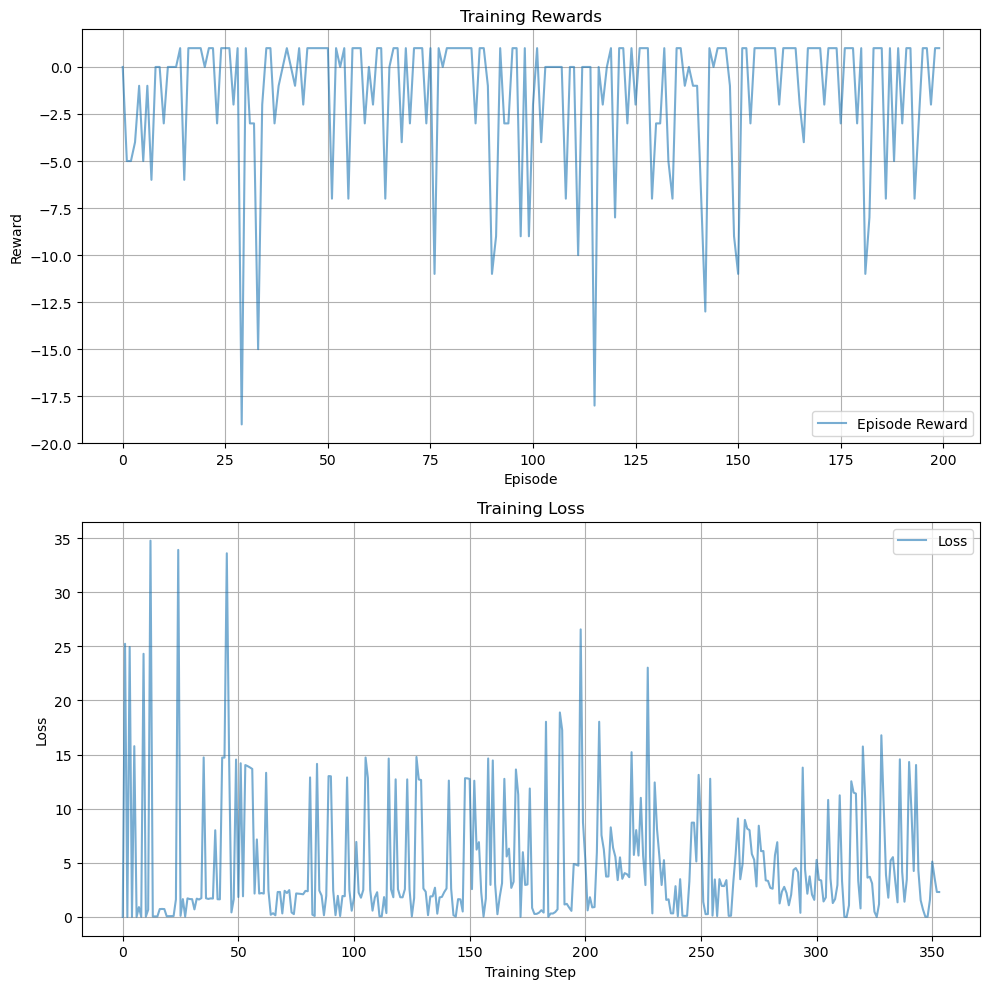

In [9]:
agent.plot_training_progress()

In [7]:
# 定义 State-Action Embedding 和 Q-Network
class StateActionEmbedding(nn.Module):
    def __init__(self, state_dim, action_dim, embedding_dim=64):
        super(StateActionEmbedding, self).__init__()
        self.state_embedding = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
        self.action_embedding = nn.Sequential(
            nn.Linear(action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, state, action):
        state_embed = self.state_embedding(state)
        action_embed = self.action_embedding(action)
        return torch.cat([state_embed, action_embed], dim=-1)

class QNetwork(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state_action_embed):
        return self.fc(state_action_embed)

# 定义 DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, embedding_dim=64, gamma=0.99, lr=1e-3, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.embedding_dim = embedding_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.episode_rewards = []
        self.losses=[]

        # 初始化网络
        self._init_networks()

        # 优化器
        self.optimizer = optim.Adam(list(self.embedding_net.parameters()) + list(self.q_net.parameters()), lr=lr)

        # 经验回放
        self.memory = deque(maxlen=10000)

    def _init_networks(self):
        """初始化嵌入网络和 Q 网络"""
        self.embedding_net = StateActionEmbedding(self.state_dim, self.action_dim, self.embedding_dim)
        self.q_net = QNetwork(self.embedding_dim)
        self.target_q_net = QNetwork(self.embedding_dim)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

    def update_networks(self, new_state_dim, new_action_dim):
        """更新网络以适应新的 state 和 action 维度"""
        # 保存当前网络的参数
        embedding_net_state_dict = self.embedding_net.state_dict()
        q_net_state_dict = self.q_net.state_dict()

        # 更新维度
        self.state_dim = new_state_dim
        self.action_dim = new_action_dim

        # 重新初始化网络
        self._init_networks()

        # 加载之前保存的参数（如果可能）
        self._load_previous_params(embedding_net_state_dict, q_net_state_dict)

    def _load_previous_params(self, embedding_net_state_dict, q_net_state_dict):
        """加载之前保存的网络参数"""
        # 加载 embedding_net 的参数
        new_embedding_net_state_dict = self.embedding_net.state_dict()
        for key in embedding_net_state_dict:
            if key in new_embedding_net_state_dict and embedding_net_state_dict[key].shape == new_embedding_net_state_dict[key].shape:
                new_embedding_net_state_dict[key] = embedding_net_state_dict[key]
        self.embedding_net.load_state_dict(new_embedding_net_state_dict)

        # 加载 q_net 的参数
        new_q_net_state_dict = self.q_net.state_dict()
        for key in q_net_state_dict:
            if key in new_q_net_state_dict and q_net_state_dict[key].shape == new_q_net_state_dict[key].shape:
                new_q_net_state_dict[key] = q_net_state_dict[key]
        self.q_net.load_state_dict(new_q_net_state_dict)

    def get_action(self, state, state_to_index):
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_dim - 1)  # 随机动作
        else:
            state_index = state_to_index[state]  # 将 state 转换为索引
            state_one_hot = torch.zeros(self.state_dim).unsqueeze(0)
            state_one_hot[0, state_index] = 1  # 转换为 one-hot 编码
            q_values = []
            for action in range(self.action_dim):
                action_one_hot = torch.zeros(self.action_dim).unsqueeze(0)
                action_one_hot[0, action] = 1
                state_action_embed = self.embedding_net(state_one_hot, action_one_hot)
                q_value = self.q_net(state_action_embed)
                q_values.append(q_value.item())
            return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size=1, state_to_index=None):
        if len(self.memory) < batch_size:
            return

        # 从经验回放中采样一个样本（batch_size=1）
        state, action, reward, next_state, done = self.memory[-1]

        # 将 state 和 next_state 转换为 one-hot 编码
        state_index = state_to_index[state]
        state_one_hot = torch.zeros(self.state_dim).unsqueeze(0)
        state_one_hot[0, state_index] = 1

        next_state_index = state_to_index[next_state]
        next_state_one_hot = torch.zeros(self.state_dim).unsqueeze(0)
        next_state_one_hot[0, next_state_index] = 1

        # 将 action 转换为 one-hot 编码
        action_one_hot = torch.zeros(self.action_dim).unsqueeze(0)
        action_one_hot[0, action] = 1

        reward = torch.FloatTensor([reward])
        done = torch.FloatTensor([done])

        # 计算当前 Q 值
        state_action_embed = self.embedding_net(state_one_hot, action_one_hot)
        current_q = self.q_net(state_action_embed)

        # 计算目标 Q 值
        with torch.no_grad():
            next_q_values = []
            for next_action in range(self.action_dim):
                next_action_one_hot = torch.zeros(self.action_dim).unsqueeze(0)
                next_action_one_hot[0, next_action] = 1
                next_state_action_embed = self.embedding_net(next_state_one_hot, next_action_one_hot)
                next_q = self.target_q_net(next_state_action_embed)
                next_q_values.append(next_q.item())
            next_q_max = max(next_q_values)
            target_q = reward + (1 - done) * self.gamma * next_q_max

        # 计算损失并更新网络
        loss = nn.MSELoss()(current_q, target_q.unsqueeze(1))  # 调整 target_q 的形状
        self.optimizer.zero_grad()
        self.losses.append(loss.item())
        loss.backward()
        self.optimizer.step()

        # 更新 epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # 更新目标网络
        self.target_q_net.load_state_dict(self.q_net.state_dict())
        
    def plot_training_progress(self):
        """绘制训练过程中的reward变化"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # 绘制episode rewards
        ax1.plot(self.episode_rewards, label='Episode Reward', alpha=0.6)
        ax1.set_title('Training Rewards')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')
        ax1.legend()
        ax1.grid(True)
        
        # 绘制损失变化
        ax2.plot(self.losses, label='Loss', alpha=0.6)
        ax2.set_title('Training Loss')
        ax2.set_xlabel('Training Step')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()


In [8]:
# 初始化环境和 Agent
env = TaskEnv_drift()  # 你的环境
state_dim = len(env.states)  # state 的维度
action_dim = len(env.motions)  # action 的维度

# 创建 state 到索引的映射
state_to_index = {state: idx for idx, state in enumerate(env.states)}
action_to_index = {action: idx for idx, action in enumerate(env.motions)}

agent = DQNAgent(state_dim, action_dim)


/Users/veetin/Desktop/drifttest_pa/main/dynamic_env.py:47: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错


In [9]:
env=TaskEnv_drift()

num_episodes = 100
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    if episode==10:
        print('drift at episode',episode)
        drift_control(5,5)

    # 检查是否有新的 state 或 action 被添加
    if len(env.states) > state_dim or len(env.motions) > action_dim:
        new_state_dim = len(env.states)
        new_action_dim = len(env.motions)
        agent.update_networks(new_state_dim, new_action_dim)
        state_dim = new_state_dim
        action_dim = new_action_dim
        state_to_index = {state: idx for idx, state in enumerate(env.states)}
        action_to_index = {action: idx for idx, action in enumerate(env.motions)}

    while True:
        action = agent.get_action(state, state_to_index)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train(batch_size=1, state_to_index=state_to_index)

        total_reward += reward
        state = next_state

        if done:
            break
    agent.episode_rewards.append(total_reward)

    #print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")


/Users/veetin/Desktop/drifttest_pa/main/dynamic_env.py:47: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错


drift at episode 10
drift happen
['a0', 'a1', 'a2', 'a3', 'a4']


In [13]:
agent.episode_rewards

[-14.0,
 1.0,
 -4.0,
 0.0,
 -1.0,
 1.0,
 1.0,
 -8.0,
 0.0,
 0.0,
 -8.0,
 0.0,
 -23.0,
 -7.0,
 -18.0,
 -13.0,
 -15.0,
 -7.0,
 1.0,
 -18.0]

In [10]:
data_eps =  {'drift': agent.episode_rewards}
df_eps = pd.DataFrame(data=data_eps)
fug = px.line(data_eps, y=['drift'])
fug.update_layout(xaxis_title = 'Episodes', yaxis_title = 'Average sum of reward')
fug.show()